# Stephen Grivers - ISA310 -  Data Visualization - Final Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from matplotlib import rcParams
import plotly.express as px
import plotly.graph_objects as go

# Project Scope

I will use Fantasy Football data to find insights on NFL positional value.

The data source is FantasyFootballDataPros and can be found here:

https://www.fantasyfootballdatapros.com/

or here:

https://github.com/fantasydatapros/data .

A secondary benefit of this project will be to get more comfortable working with NFL data for my Honors Thesis about evaluating NFL Player Value in general.  That project will  use real NFL data rather than Fantasy Football data, but I think fantasy football data is an easier way to get my foot in the door, since it has a clear target variable - Fantasy Points.

# Question 1: Has the usage of a primary Running Back changed over time towards more "committees"?

## Reading in the Data

FantasyFootballDataPros has .csv files for each year of the NFL, going back to 1970.  To use this, I will use the glob library to import multiple dataframes.  I will then add a 'Year' column so that each year of data can be compared, and combine each year into one DataFrame.

In [2]:
path = r'C:/Users/student/Desktop/ISA/Data Visualization/data/fantasy_data/yearly'
filenames = glob.glob(path + "/*.csv")
dfs = []
for filename in filenames:
    df = pd.read_csv(filename)
    year = filename[73:77]
    df['Year'] = year
    df = df[df['Pos'] == 'RB'] #We only want to find the number one RB, not number one from any position.
    df = df.groupby('Tm').apply(lambda x: x.nlargest(1, ['FantasyPoints']).min()).reset_index(drop=True)
    #The above line of code reads in only each team's RB1 for each season.  Easiest place to do this is before concatenating the years.
    dfs.append(df)

# Concatenate all data into one DataFrame
big_frame = pd.concat(dfs, ignore_index=True)

In [3]:
big_frame.columns

Index(['Unnamed: 0', 'Player', 'Tm', 'Pos', 'Age', 'G', 'GS', 'Cmp', 'Att',
       'Yds', 'Int', 'Att.1', 'Yds.1', 'Rec', 'Yds.2', 'Y/R', 'Fumbles',
       'FumblesLost', 'PassingYds', 'PassingTD', 'PassingAtt', 'RushingYds',
       'RushingTD', 'RushingAtt', 'ReceivingYds', 'ReceivingTD',
       'FantasyPoints', 'Year', 'Tgt'],
      dtype='object')

## Preprocessing DataFrame

In [4]:
df = big_frame.drop('Unnamed: 0',axis=1)
df['FantasyPoints/GM'] = np.round(df['FantasyPoints']/df['G'],2)

In [5]:
def transform_columns(df, new_column_list):
    df = df[['Player','Tm','Age','G'] + new_column_list + ['Fumbles','FumblesLost','Year','FantasyPoints','FantasyPoints/GM']]
    return df

In [6]:
rushing_columns = ['RushingAtt','RushingYds','Y/R','RushingTD']
receiving_columns = ['Tgt','Rec','ReceivingYds','ReceivingTD']

In [7]:
df_rb = transform_columns(df, rushing_columns+receiving_columns)

df_rb.head()

Player   Tm   Age     G  RushingAtt  RushingYds    Y/R  RushingTD  \
0  Mike Garrett  2TM  26.0  12.0        67.0       208.0   9.36        1.0   
1  Harmon Wages  ATL  24.0  13.0       119.0       422.0   5.88        1.0   
2  Norm Bulaich  BAL  24.0  12.0       139.0       426.0  11.18        3.0   
3     Jim Nance  BOS  28.0  13.0       145.0       522.0   5.69        7.0   
4  O.J. Simpson  BUF  23.0   8.0       120.0       488.0  13.90        5.0   

   Tgt   Rec  ReceivingYds  ReceivingTD  Fumbles  FumblesLost  Year  \
0  NaN  14.0         131.0          1.0      4.0          0.0  1970   
1  NaN  26.0         153.0          2.0      4.0          0.0  1970   
2  NaN  11.0         123.0          0.0      6.0          0.0  1970   
3  NaN  26.0         148.0          0.0      6.0          0.0  1970   
4  NaN  10.0         139.0          0.0      6.0          0.0  1970   

   FantasyPoints  FantasyPoints/GM  
0          51.90              4.33  
1          94.02              7.23  
2          71.90              5.99  
3         123.00              9.46  
4          90.70             11.34

In [8]:
df_rb.tail()

Player   Tm   Age     G  RushingAtt  RushingYds    Y/R  \
1531     Chris Carson  SEA  25.0  15.0       278.0      1230.0   7.19   
1532   Raheem Mostert  SFO  27.0  16.0       137.0       772.0  12.86   
1533     Ronald Jones  TAM  22.0  16.0       172.0       724.0   9.97   
1534    Derrick Henry  TEN  25.0  15.0       303.0      1540.0  11.44   
1535  Adrian Peterson  WAS  34.0  15.0       211.0       898.0   8.35   

      RushingTD   Tgt   Rec  ReceivingYds  ReceivingTD  Fumbles  FumblesLost  \
1531        7.0  47.0  37.0         266.0          2.0      7.0          4.0   
1532        8.0  22.0  14.0         180.0          2.0      2.0          2.0   
1533        6.0  40.0  31.0         309.0          0.0      3.0          2.0   
1534       16.0  24.0  18.0         206.0          2.0      5.0          3.0   
1535        5.0  23.0  17.0         142.0          0.0      3.0          2.0   

      Year  FantasyPoints  FantasyPoints/GM  
1531  2019          232.6             15.51  
1532  2019          165.2             10.32  
1533  2019          166.3             10.39  
1534  2019          294.6             19.64  
1535  2019          147.0              9.80

## Visualization

I want to take the average team RB1 score from each year and plot them in a time series.

In [9]:
df_rb['Year'] = pd.to_datetime(df_rb['Year'])

<ipython-input-9-e3b0b6dc9af1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rb['Year'] = pd.to_datetime(df_rb['Year'])


In [10]:
df_rb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1536 entries, 0 to 1535
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Player            1536 non-null   object        
 1   Tm                1536 non-null   object        
 2   Age               1536 non-null   float64       
 3   G                 1536 non-null   float64       
 4   RushingAtt        1536 non-null   float64       
 5   RushingYds        1536 non-null   float64       
 6   Y/R               1536 non-null   float64       
 7   RushingTD         1536 non-null   float64       
 8   Tgt               907 non-null    float64       
 9   Rec               1536 non-null   float64       
 10  ReceivingYds      1536 non-null   float64       
 11  ReceivingTD       1536 non-null   float64       
 12  Fumbles           1536 non-null   float64       
 13  FumblesLost       1536 non-null   float64       
 14  Year              1536 n

In [11]:
df_rb['AvgFantasyPointsYear'] = np.round(df_rb.groupby(df_rb['Year'].dt.year)['FantasyPoints'].transform('mean'),2)

<ipython-input-11-1c8ec7f8d310>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rb['AvgFantasyPointsYear'] = np.round(df_rb.groupby(df_rb['Year'].dt.year)['FantasyPoints'].transform('mean'),2)


In [12]:
df_rb.tail()

Player   Tm   Age     G  RushingAtt  RushingYds    Y/R  \
1531     Chris Carson  SEA  25.0  15.0       278.0      1230.0   7.19   
1532   Raheem Mostert  SFO  27.0  16.0       137.0       772.0  12.86   
1533     Ronald Jones  TAM  22.0  16.0       172.0       724.0   9.97   
1534    Derrick Henry  TEN  25.0  15.0       303.0      1540.0  11.44   
1535  Adrian Peterson  WAS  34.0  15.0       211.0       898.0   8.35   

      RushingTD   Tgt   Rec  ReceivingYds  ReceivingTD  Fumbles  FumblesLost  \
1531        7.0  47.0  37.0         266.0          2.0      7.0          4.0   
1532        8.0  22.0  14.0         180.0          2.0      2.0          2.0   
1533        6.0  40.0  31.0         309.0          0.0      3.0          2.0   
1534       16.0  24.0  18.0         206.0          2.0      5.0          3.0   
1535        5.0  23.0  17.0         142.0          0.0      3.0          2.0   

           Year  FantasyPoints  FantasyPoints/GM  AvgFantasyPointsYear  
1531 2019-01-01          232.6             15.51                207.44  
1532 2019-01-01          165.2             10.32                207.44  
1533 2019-01-01          166.3             10.39                207.44  
1534 2019-01-01          294.6             19.64                207.44  
1535 2019-01-01          147.0              9.80                207.44

In [13]:
fontsize=17

rcParams['font.size'] = fontsize
rcParams['font.family'] = 'sans-serif'

rcParams['axes.labelsize'] = fontsize
rcParams['axes.titlesize'] = fontsize
rcParams['xtick.labelsize'] = fontsize
rcParams['ytick.labelsize'] = fontsize

Text(0, 0.5, 'Average Fantasy Points')

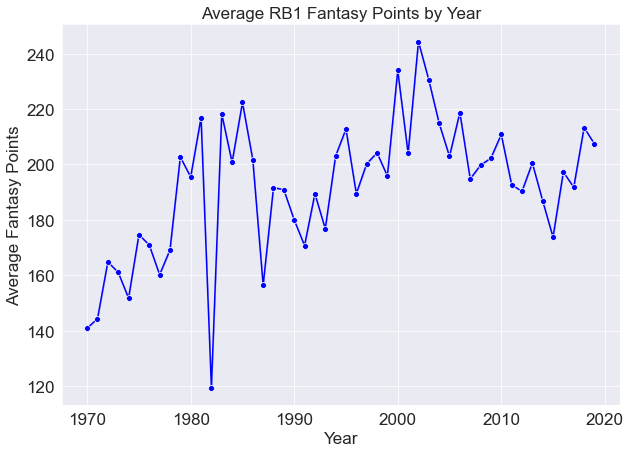

In [14]:
sns.set_style('darkgrid')
fig, ax = plt.subplots()
fig.set_size_inches(10,7)

sns.lineplot(df_rb['Year'],df_rb['AvgFantasyPointsYear'],color='blue',marker='o')
plt.title('Average RB1 Fantasy Points by Year')
plt.ylabel('Average Fantasy Points')

# Question 2: Which stats have the highest correlation with Fantasy Point production?

In [15]:
df = pd.read_csv('data/fantasy_data/yearly/2019.csv')
df.drop(['Unnamed: 0','Att.1','Yds.1','Yds.2'],axis=1,inplace=True)
df.head()

Player   Tm Pos   Age     G    GS    Cmp    Att     Yds  Int  \
0  Christian McCaffrey  CAR  RB  23.0  16.0  16.0    0.0    2.0     0.0  0.0   
1        Lamar Jackson  BAL  QB  22.0  15.0  15.0  265.0  401.0  3127.0  6.0   
2        Derrick Henry  TEN  RB  25.0  15.0  15.0    0.0    0.0     0.0  0.0   
3          Aaron Jones  GNB  RB  25.0  16.0  16.0    0.0    0.0     0.0  0.0   
4      Ezekiel Elliott  DAL  RB  24.0  16.0  16.0    0.0    0.0     0.0  0.0   

   ...  FumblesLost  PassingYds  PassingTD  PassingAtt  RushingYds  RushingTD  \
0  ...          0.0         0.0        0.0         2.0      1387.0       15.0   
1  ...          2.0      3127.0       36.0       401.0      1206.0        7.0   
2  ...          3.0         0.0        0.0         0.0      1540.0       16.0   
3  ...          2.0         0.0        0.0         0.0      1084.0       16.0   
4  ...          2.0         0.0        0.0         0.0      1357.0       12.0   

   RushingAtt  ReceivingYds  ReceivingTD  FantasyPoints  
0       287.0        1005.0          4.0         469.20  
1       176.0           0.0          0.0         415.68  
2       303.0         206.0          2.0         294.60  
3       236.0         474.0          3.0         314.80  
4       301.0         420.0          2.0         311.70  

[5 rows x 24 columns]

Text(0.5, 1.0, 'Which stats have the highest correlation with Fantasy Point production?')

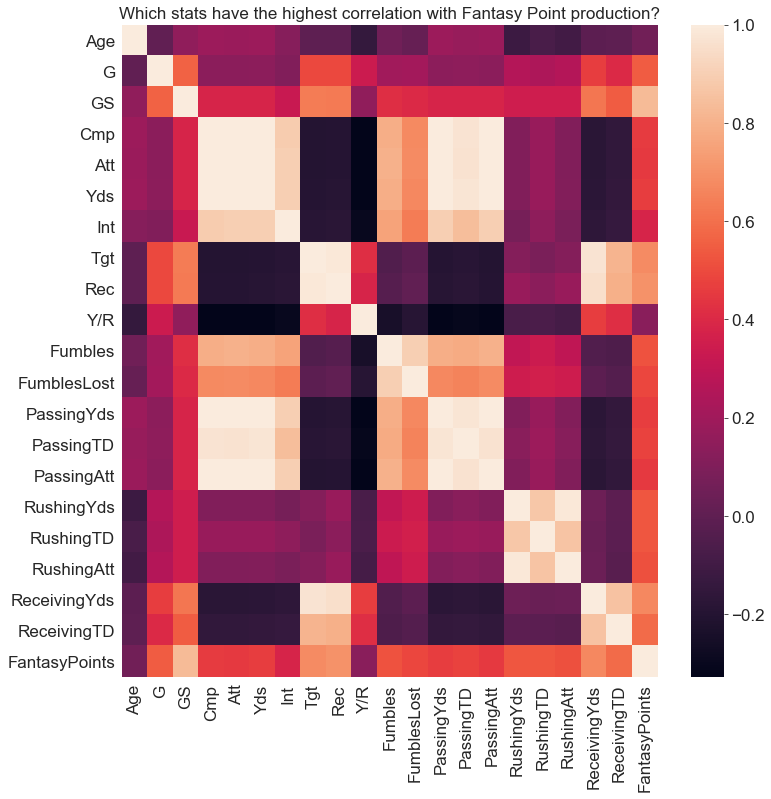

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(12,12)

corr_matrix = df.corr()
sns.heatmap(corr_matrix)
plt.title('Which stats have the highest correlation with Fantasy Point production?')

The most correlated stats are GS, and Receptions.

# Question 3: Are fantasy football rankings reliable? Or is there a better way to choose players?

([], <a list of 0 Text major ticklabel objects>)

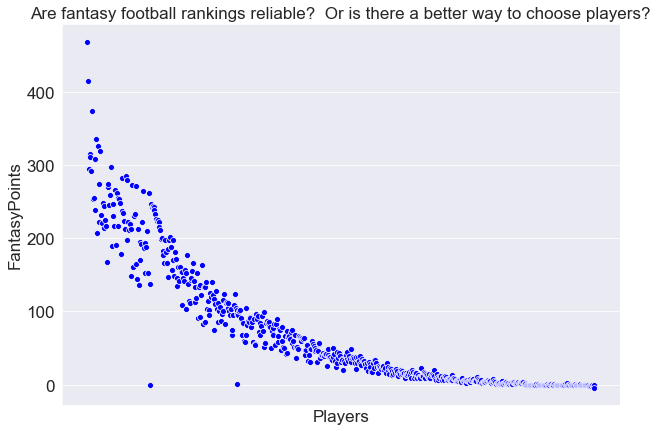

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(10,7)

sns.scatterplot(data=df,x='Player',y='FantasyPoints',color='blue')
plt.title('Are fantasy football rankings reliable?  Or is there a better way to choose players?')
plt.xlabel('Players')
plt.xticks([])

# Question 4: How often do mid-season pickups reach the top of their position's ranks?

## Getting the Top 20 Running Backs

In [18]:
year_frame = pd.read_csv('data/fantasy_data/yearly/2019.csv')
year_frame = year_frame[year_frame['Pos']=='RB']
#year_frame['AvgFantasyPoints'] = np.round(year_frame['FantasyPoints']/year_frame['G'],2)

df_top30 = year_frame.nlargest(30,'FantasyPoints')
df_RB3s = df_top30.tail(10)
df_RB3s['Player'].tolist()

['Josh Jacobs',
 'Melvin Gordon',
 'Marlon Mack',
 'David Montgomery',
 'Ronald Jones',
 'Raheem Mostert',
 'Tarik Cohen',
 'Latavius Murray',
 'Duke Johnson',
 'Carlos Hyde']

# Loading in the Weekly Data

In [19]:
# Load data
path = r'C:/Users/student/Desktop/ISA/Data Visualization/data/fantasy_data/weekly/2019'
filenames = glob.glob(path + "/*.csv")
dfs = []
Week = 1
for filename in filenames:
    df = pd.read_csv(filename)
    df['Week'] = Week
    Week +=1
    df = df[df['Pos'] == 'RB'] #We will focus on RBs for simplicity
    dfs.append(df)

# Concatenate all data into one DataFrame
weekly_frame = pd.concat(dfs, ignore_index=True)
weekly_frame.head()

Player Pos   Tm  PassingYds  PassingTD  Int  PassingAtt  Cmp  \
0          Marlon Mack  RB  IND         0.0        0.0  0.0         0.0  0.0   
1  Christian McCaffrey  RB  CAR         0.0        0.0  0.0         0.0  0.0   
2       Saquon Barkley  RB  NYG         0.0        0.0  0.0         0.0  0.0   
3          Dalvin Cook  RB  MIN         0.0        0.0  0.0         0.0  0.0   
4          Mark Ingram  RB  BAL         0.0        0.0  0.0         0.0  0.0   

   RushingAtt  RushingYds  RushingTD   Rec   Tgt  ReceivingYds  ReceivingTD  \
0        25.0       174.0        1.0   0.0   0.0           0.0          0.0   
1        19.0       128.0        2.0  10.0  11.0          81.0          0.0   
2        11.0       120.0        0.0   4.0   6.0          19.0          0.0   
3        21.0       111.0        2.0   2.0   2.0           9.0          0.0   
4        14.0       107.0        2.0   0.0   0.0           0.0          0.0   

    FL  PPRFantasyPoints  StandardFantasyPoints  HalfPPRFantasyPoints  Week  
0  0.0              23.4                   23.4                  23.4     1  
1  0.0              42.9                   32.9                  37.9     1  
2  0.0              17.9                   13.9                  15.9     1  
3  0.0              26.0                   24.0                  25.0     1  
4  0.0              22.7                   22.7                  22.7     1

In [20]:
list_rb3s = ['Josh Jacobs','Melvin Gordon','Marlon Mack','David Montgomery','Ronald Jones','Raheem Mostert','Tarik Cohen','Latavius Murray','Duke Johnson','Carlos Hyde']
weekly_rb3s = weekly_frame[weekly_frame['Player'].isin(list_rb3s)]

In [21]:
fig = px.line(weekly_rb3s, x="Week", y="PPRFantasyPoints", color="Player",line_shape='spline')
fig.update_layout(title='Are the RBs ranked 20-30 Waiver Pickups or were they drafted?')
fig.show()

# Question 5: Which RBs' values are the most affected by whether of not a fantasy league uses Points Per Reception (PPR) scoring?

In [22]:
year_frame = pd.read_csv('data/fantasy_data/yearly/2019.csv')
year_frame = year_frame[year_frame['Pos']=='RB']

df = year_frame
df.head()

Unnamed: 0               Player   Tm Pos   Age     G    GS  Cmp  Att  Yds  \
0           0  Christian McCaffrey  CAR  RB  23.0  16.0  16.0  0.0  2.0  0.0   
2           2        Derrick Henry  TEN  RB  25.0  15.0  15.0  0.0  0.0  0.0   
3           3          Aaron Jones  GNB  RB  25.0  16.0  16.0  0.0  0.0  0.0   
4           4      Ezekiel Elliott  DAL  RB  24.0  16.0  16.0  0.0  0.0  0.0   
5           5          Dalvin Cook  MIN  RB  24.0  14.0  14.0  0.0  0.0  0.0   

   ...  FumblesLost  PassingYds  PassingTD  PassingAtt  RushingYds  RushingTD  \
0  ...          0.0         0.0        0.0         2.0      1387.0       15.0   
2  ...          3.0         0.0        0.0         0.0      1540.0       16.0   
3  ...          2.0         0.0        0.0         0.0      1084.0       16.0   
4  ...          2.0         0.0        0.0         0.0      1357.0       12.0   
5  ...          2.0         0.0        0.0         0.0      1135.0       13.0   

   RushingAtt  ReceivingYds  ReceivingTD  FantasyPoints  
0       287.0        1005.0          4.0          469.2  
2       303.0         206.0          2.0          294.6  
3       236.0         474.0          3.0          314.8  
4       301.0         420.0          2.0          311.7  
5       250.0         519.0          0.0          292.4  

[5 rows x 28 columns]

## Calculating Standard FantasyPoints vs PPR FantasyPoints

In Points-Per-Reception leagues, a point is given for Receptions, and in Standard leagues, this point is not given.  PPR leagues were created to balance out the RB and WR positions.  However, with the increase in "pass catching RBs", some question whether this change makes RBs who get a lot of Rushes AND Receptions even stronger than before.

In [23]:
df['StdFantasyPoints'] = np.round(df['RushingYds']*0.1 + df['RushingTD']*6 + df['Rec']*0  # <----- 0 Points per reception
                          + df['ReceivingYds']*0.1 + df['ReceivingTD']*6 - df['FumblesLost']*2,2)

df['PPRFantasyPoints'] = np.round(df['RushingYds']*0.1 + df['RushingTD']*6 + df['Rec']*1 # <----- 1 Point per reception
                          + df['ReceivingYds']*0.1 + df['ReceivingTD']*6 - df['FumblesLost']*2,2)

In [24]:
df.head()

Unnamed: 0               Player   Tm Pos   Age     G    GS  Cmp  Att  Yds  \
0           0  Christian McCaffrey  CAR  RB  23.0  16.0  16.0  0.0  2.0  0.0   
2           2        Derrick Henry  TEN  RB  25.0  15.0  15.0  0.0  0.0  0.0   
3           3          Aaron Jones  GNB  RB  25.0  16.0  16.0  0.0  0.0  0.0   
4           4      Ezekiel Elliott  DAL  RB  24.0  16.0  16.0  0.0  0.0  0.0   
5           5          Dalvin Cook  MIN  RB  24.0  14.0  14.0  0.0  0.0  0.0   

   ...  PassingTD  PassingAtt  RushingYds  RushingTD  RushingAtt  \
0  ...        0.0         2.0      1387.0       15.0       287.0   
2  ...        0.0         0.0      1540.0       16.0       303.0   
3  ...        0.0         0.0      1084.0       16.0       236.0   
4  ...        0.0         0.0      1357.0       12.0       301.0   
5  ...        0.0         0.0      1135.0       13.0       250.0   

   ReceivingYds  ReceivingTD  FantasyPoints  StdFantasyPoints  \
0        1005.0          4.0          469.2             353.2   
2         206.0          2.0          294.6             276.6   
3         474.0          3.0          314.8             265.8   
4         420.0          2.0          311.7             257.7   
5         519.0          0.0          292.4             239.4   

   PPRFantasyPoints  
0             469.2  
2             294.6  
3             314.8  
4             311.7  
5             292.4  

[5 rows x 30 columns]

It looks like the data source's 'FantasyPoints' column already was PPR FantasyPoints, but it was still worth verifying.  Now, we will calculate the difference and percent difference between PPR and Standard points.

In [25]:
df['Difference'] = np.round(df['PPRFantasyPoints'] - df['StdFantasyPoints'],2)

df['PercentDifference'] = np.round(((df['PPRFantasyPoints'] - df['StdFantasyPoints'])/df['StdFantasyPoints']) *100,0)

df.head()

Unnamed: 0               Player   Tm Pos   Age     G    GS  Cmp  Att  Yds  \
0           0  Christian McCaffrey  CAR  RB  23.0  16.0  16.0  0.0  2.0  0.0   
2           2        Derrick Henry  TEN  RB  25.0  15.0  15.0  0.0  0.0  0.0   
3           3          Aaron Jones  GNB  RB  25.0  16.0  16.0  0.0  0.0  0.0   
4           4      Ezekiel Elliott  DAL  RB  24.0  16.0  16.0  0.0  0.0  0.0   
5           5          Dalvin Cook  MIN  RB  24.0  14.0  14.0  0.0  0.0  0.0   

   ...  RushingYds  RushingTD  RushingAtt  ReceivingYds  ReceivingTD  \
0  ...      1387.0       15.0       287.0        1005.0          4.0   
2  ...      1540.0       16.0       303.0         206.0          2.0   
3  ...      1084.0       16.0       236.0         474.0          3.0   
4  ...      1357.0       12.0       301.0         420.0          2.0   
5  ...      1135.0       13.0       250.0         519.0          0.0   

   FantasyPoints  StdFantasyPoints  PPRFantasyPoints  Difference  \
0          469.2             353.2             469.2       116.0   
2          294.6             276.6             294.6        18.0   
3          314.8             265.8             314.8        49.0   
4          311.7             257.7             311.7        54.0   
5          292.4             239.4             292.4        53.0   

   PercentDifference  
0               33.0  
2                7.0  
3               18.0  
4               21.0  
5               22.0  

[5 rows x 32 columns]

In [26]:
df_top10 = year_frame.nlargest(10,'Difference')
df_PPR_RBs = df_top10
df_PPR_RBs['Player'].tolist()

['Christian McCaffrey',
 'Austin Ekeler',
 'Alvin Kamara',
 'Tarik Cohen',
 'Leonard Fournette',
 'James White',
 "Le'Veon Bell",
 'Devonta Freeman',
 'Ezekiel Elliott',
 'Dalvin Cook']

In [27]:
df = df_PPR_RBs[['Player','Rec','StdFantasyPoints','PPRFantasyPoints','Difference','PercentDifference']]

In [28]:
fig = go.Figure(data=[go.Table(
    header=dict(values=df.columns,
                fill_color='turquoise',
                align='left'),
    cells=dict(values=[df['Player'],df['Rec'],df['StdFantasyPoints'],df['PPRFantasyPoints'],df['Difference'],df['PercentDifference']],
               fill_color='lightcyan',
               align='left'))
])
fig.show()

In [29]:
fig = px.bar(df, x='Player',y='Difference', color='PercentDifference',color_continuous_scale='blues')
fig.show()

# Conclusion

Although I was not able to figure out how to do all of the interactive plotting I considered in my Final Project Proposal, I am happy with the insights I found.

My main takeaways are:

* RB1 scoring over the years does not suggest a shift towards committees - in fact, it suggests the opposite.  Maybe this is due to an 'inflation' of offensive production across the board?


* The most correlated metrics with FantasyPoints are Games Started (GS) and Receptions.  If FantasyPoints was not based on a PPR scoring system, would Receptions be as correlated?


* Fantasy Rankings are not the end-all, be-all of valuing players, as there is an exponential decline in scoring as you go down the ranks, rather than the linear decline (of 1 rank) between each ranked player.


* Most RB3s are great on specific weeks of the year, rather than being consistently mediocre.


* The most-affected RBs in PPR leagues are mostly the top scoring RBs in Standard leagues as well.  This means that PPR scoring is making the best RBs even stronger, rather than balancing the best WRs with them.


If I had more time, I would work on how to make a 'search bar' feature, so that instead of filtering my dataframes manually, the user could input the name of a player and pull up visualizations for that specific player.